# Build SPX Metrics 

Show equity metrics by name and by sector.

In [1]:

# ----------------------------------------
# CONFIGURATION
# ----------------------------------------
index_name = 'SPX Index'
output_file = '../data/spx_metrics.xlsx'

TRIM_OUTLIERS = False

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib import patches as mpatches
from xbbg import blp

# ----------------------------------------
# FETCH SPX CONSTITUENTS
# ----------------------------------------
spx_members = blp.bds(index_name, 'INDX_MEMBERS')
ticker_cols = [c for c in spx_members.columns if 'ticker' in c.lower()]
if len(spx_members.columns) == 1:
    raw_tickers = spx_members.iloc[:, 0]
elif ticker_cols:
    raw_tickers = spx_members[ticker_cols[0]]
else:
    raw_tickers = spx_members.iloc[:, 0]
tickers = raw_tickers.astype(str).str.strip().tolist()
tickers = [t if t.lower().endswith('equity') else f"{t} Equity" for t in tickers]

# ----------------------------------------
# DEFINE AND FETCH METRIC FIELDS
# ----------------------------------------
fields = [
    'DIVIDEND_YIELD',
    'PX_TO_BOOK_RATIO',
    'PE_RATIO',    
    'NET_DEBT_TO_SHRHLDR_EQTY',
    'VOLATILITY_90D',
    'EQY_BETA',
    'EBITDA_MARGIN',
    'RETURN_ON_AVG_INV_CAPITAL',
    'NET_MARGIN',
    'EQY_SHARPE_RATIO',
    'CUR_MKT_CAP',
    'GICS_SECTOR_NAME'
]
bdp_df = blp.bdp(tickers, flds=fields)
bdp_df.index.name = 'ticker'
bdp_df.columns = [c.lower() for c in bdp_df.columns]

# ----------------------------------------
# CENSOR SEVERE OUTLIERS (3*IQR rule) FOR EACH METRIC
# ----------------------------------------
metrics = [c.lower() for c in fields if c.lower() not in ('cur_mkt_cap', 'gics_sector_name')]
if TRIM_OUTLIERS:
    for m in metrics:
        if m in bdp_df.columns:
            series = pd.to_numeric(bdp_df[m], errors='coerce')
            q1 = series.quantile(0.25)
            q3 = series.quantile(0.75)
            iqr = q3 - q1
            lower, upper = q1 - 3 * iqr, q3 + 3 * iqr
            mask = (series < lower) | (series > upper)
            bdp_df.loc[mask, m] = pd.NA

# ----------------------------------------
# VALUE-WEIGHTED SECTOR AGGREGATION
# ----------------------------------------
def weighted_mean(df, col, weight_col='cur_mkt_cap'):
    vals = pd.to_numeric(df[col], errors='coerce')
    w = pd.to_numeric(df[weight_col], errors='coerce')
    mask = vals.notna() & w.notna()
    return (vals[mask] * w[mask]).sum() / w[mask].sum() if mask.sum() else pd.NA

sector_list = []
for sector, grp in bdp_df.groupby('gics_sector_name'):
    stats = {}
    for m in metrics:
        if m in grp.columns:
            stats[m] = weighted_mean(grp, m)
    stats['cur_mkt_cap'] = pd.to_numeric(grp['cur_mkt_cap'], errors='coerce').sum()
    sector_list.append(pd.Series(stats, name=sector))
sector_metrics = pd.concat(sector_list, axis=1).T
sector_metrics['mkt_cap_weight'] = sector_metrics['cur_mkt_cap'] / sector_metrics['cur_mkt_cap'].sum()


sector_metrics.index.name = 'gics_sector_name'

In [3]:
# ----------------------------------------
# EXPORT TO EXCEL
# ----------------------------------------

with pd.ExcelWriter(output_file) as writer:
    bdp_df.to_excel(writer, sheet_name='Single Name Stats')
    sector_metrics.to_excel(writer, sheet_name='Sector Stats')
    names = blp.bdp(tickers, flds='LONG_COMP_NAME')
    names.index.name = 'ticker'
    names.to_excel(writer, sheet_name='Ticker Names')

print(f"Exported metrics to {output_file}")


Exported metrics to ../data/spx_metrics.xlsx


/var/folders/zx/3v_qt0957xzg3nqtnkv007d00000gn/T/ipykernel_4374/2578127923.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('tab20', len(sectors))


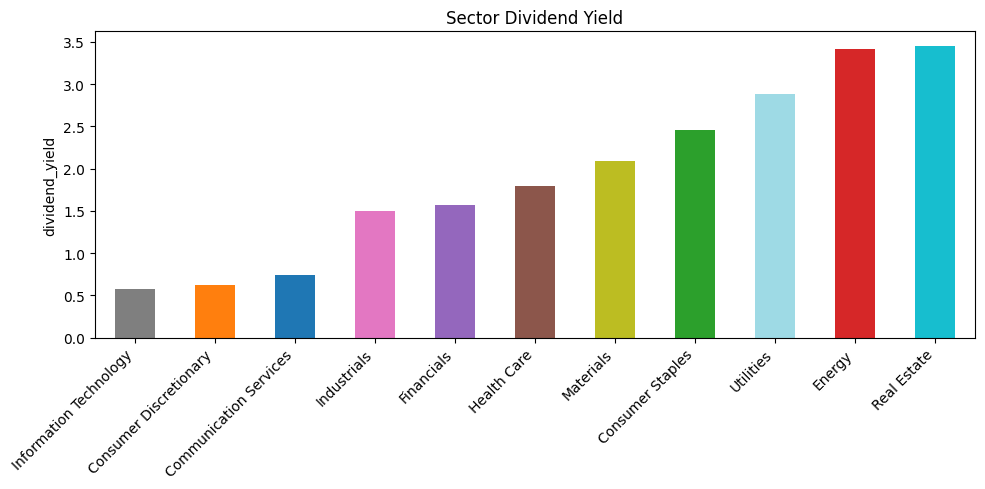

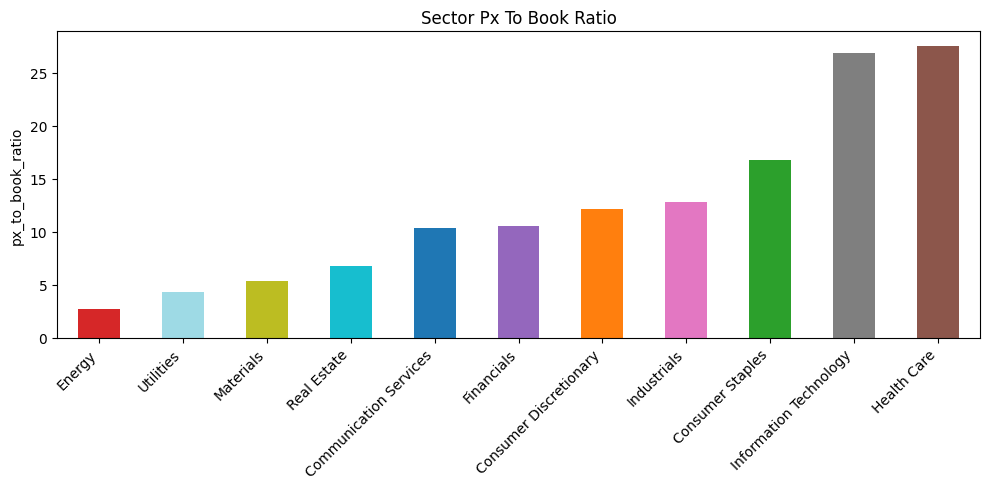

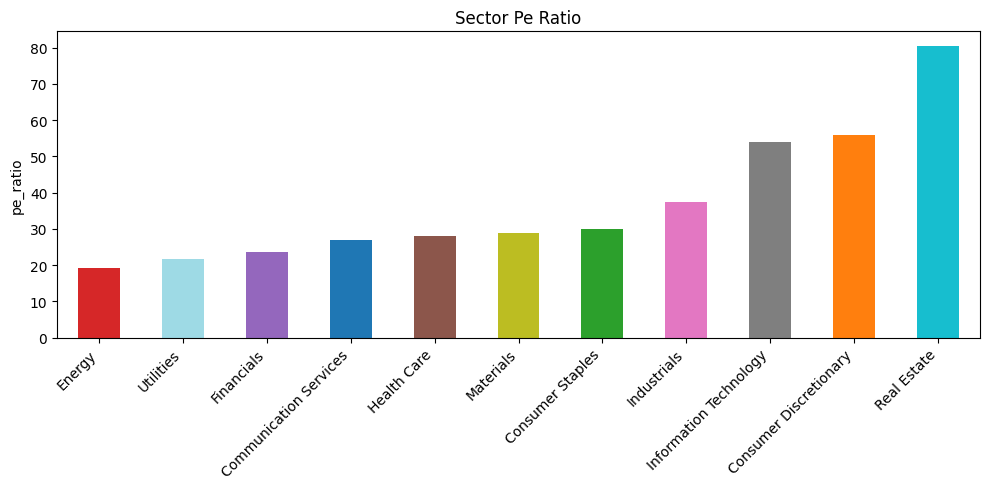

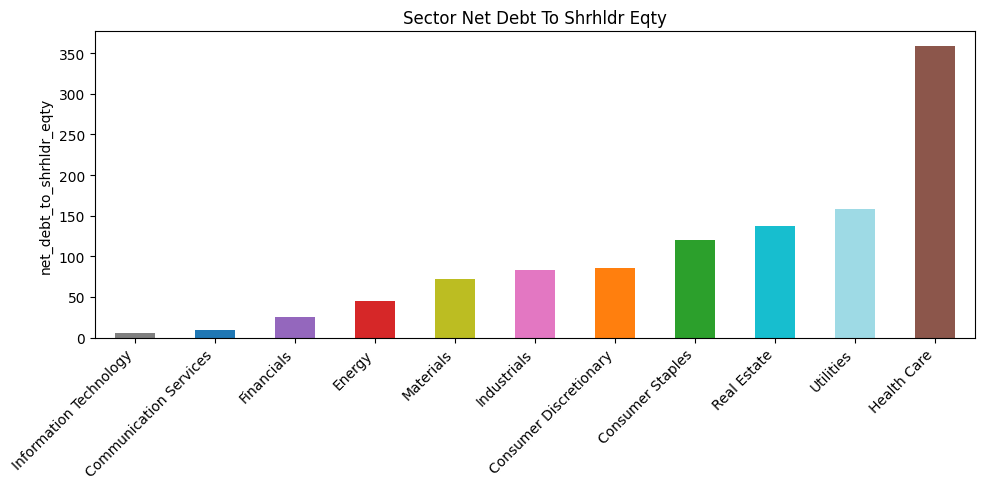

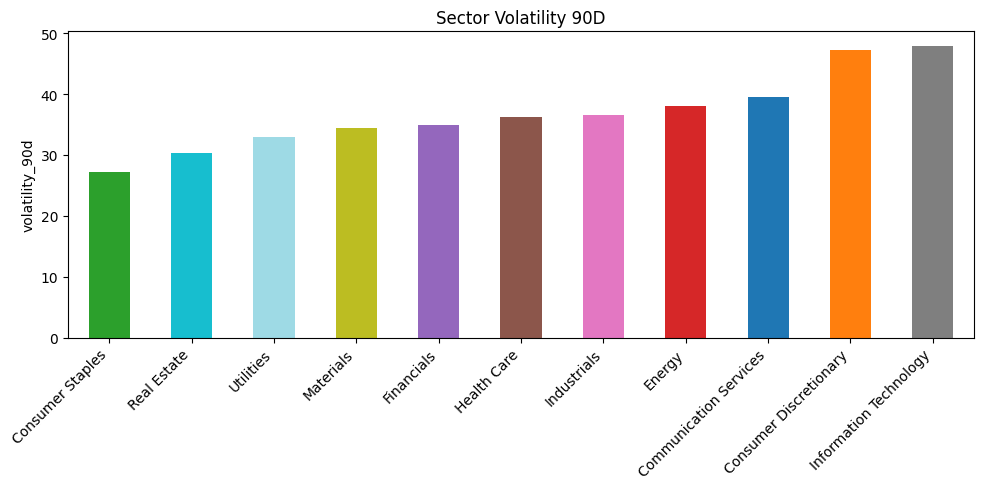

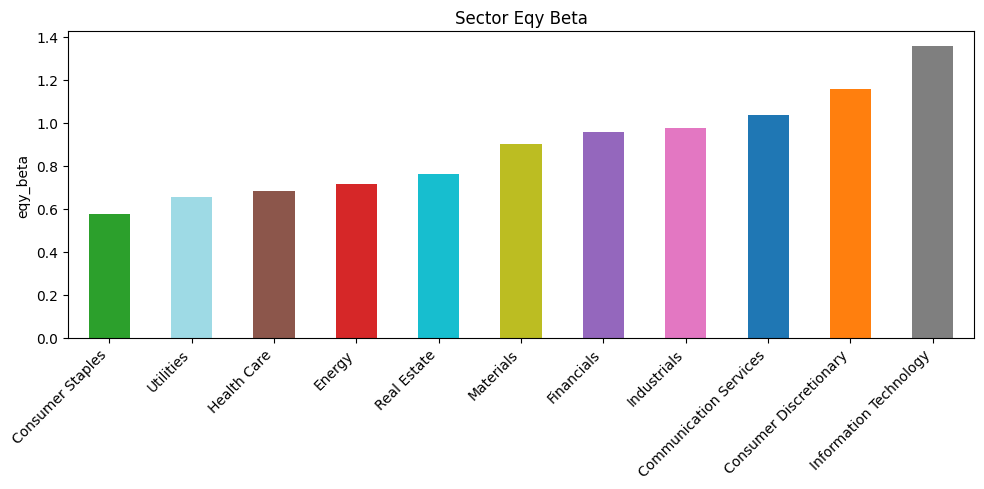

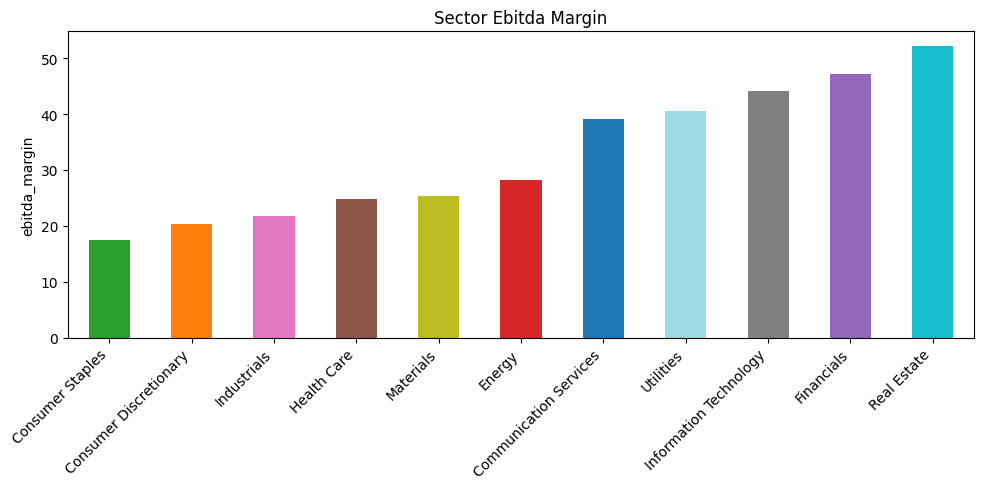

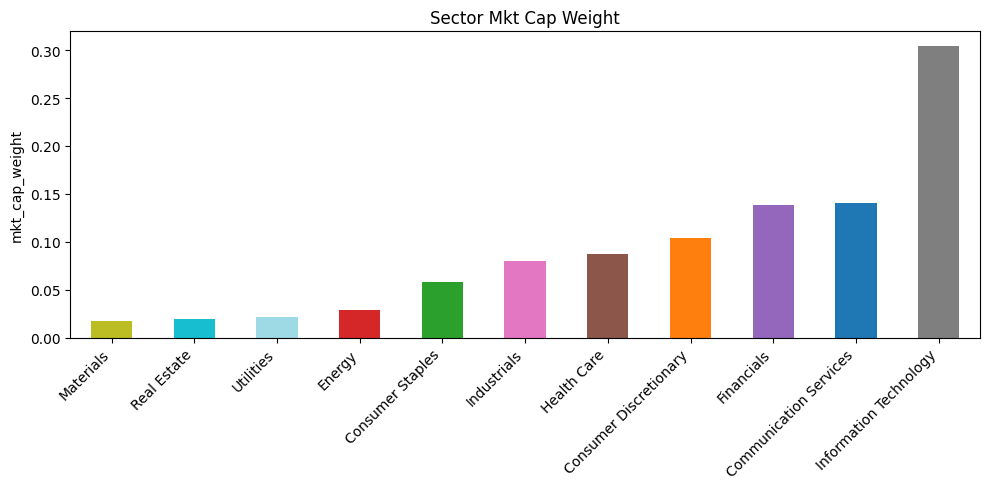

In [4]:
# # ----------------------------------------
# # PREPARE SECTOR COLOR MAP
# # ----------------------------------------
# sectors = sector_metrics.index.tolist()
# cmap = get_cmap('tab20', len(sectors))
# color_map = {s: cmap(i) for i, s in enumerate(sectors)}

# # ----------------------------------------
# # VISUALIZE SECTOR VARIATION
# # ----------------------------------------
# for metric in sector_metrics.columns:
#     if metric == 'cur_mkt_cap': continue
#     vals = sector_metrics[metric].sort_values()
#     colors = [color_map[s] for s in vals.index]
#     plt.figure(figsize=(10, 5))
#     vals.plot(kind='bar', color=colors)
#     plt.title(f"Sector {metric.replace('_', ' ').title()}")
#     plt.ylabel(metric)
#     plt.xticks(rotation=45, ha='right')
#     plt.tight_layout()
#     plt.show()

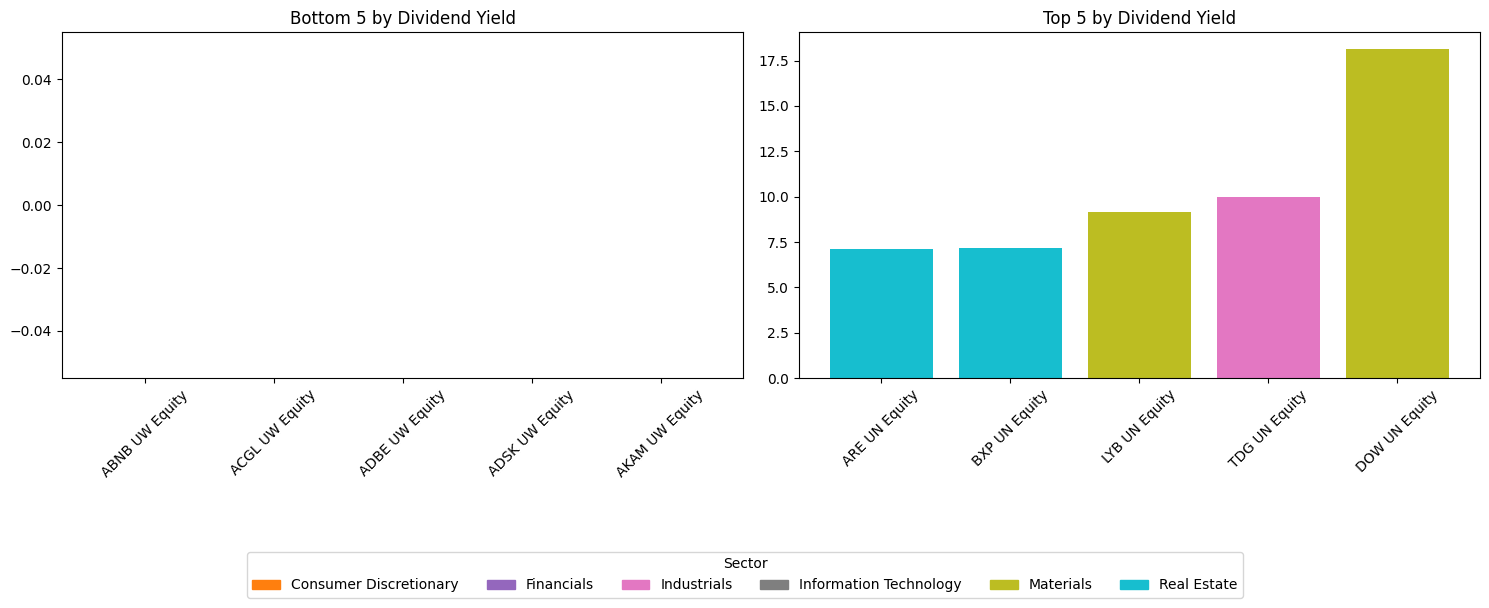

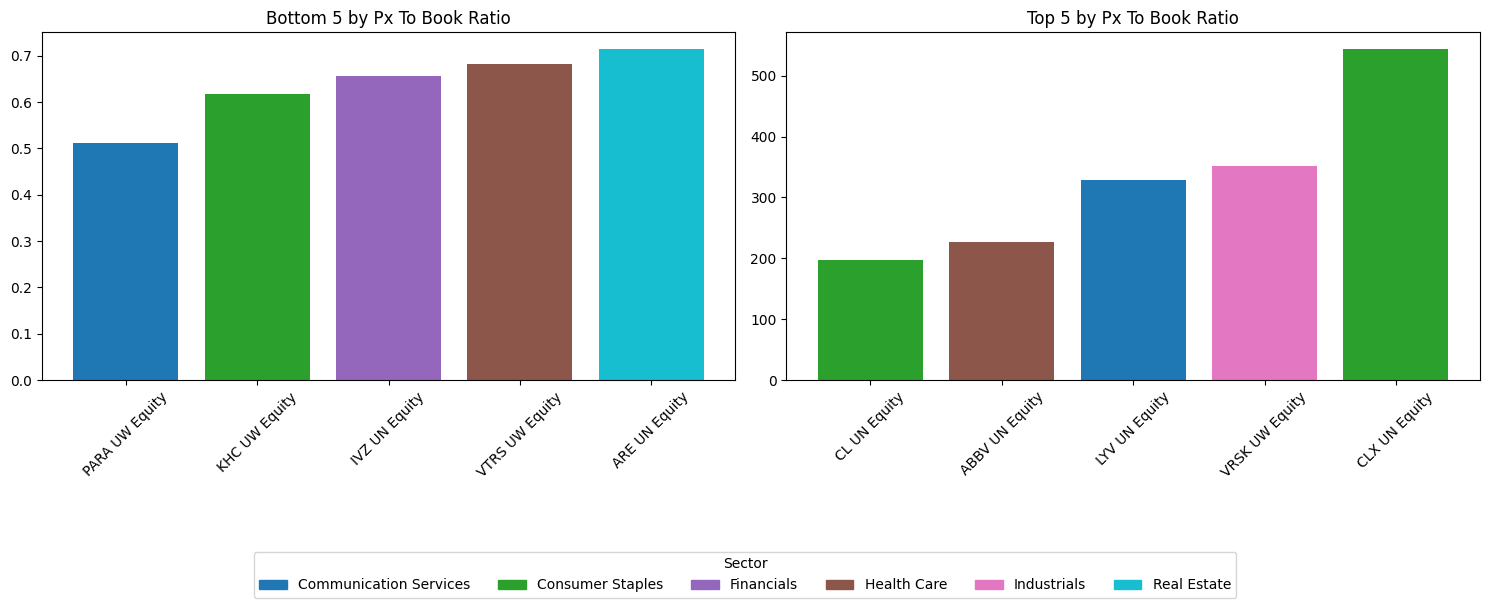

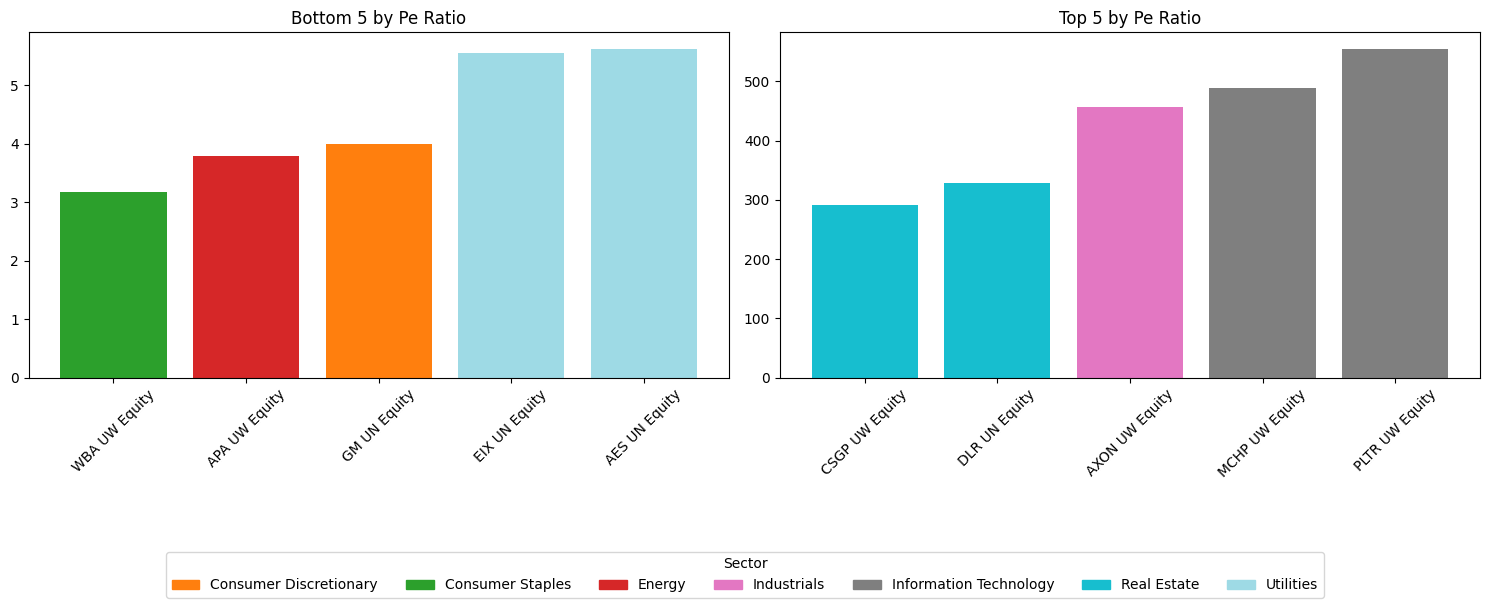

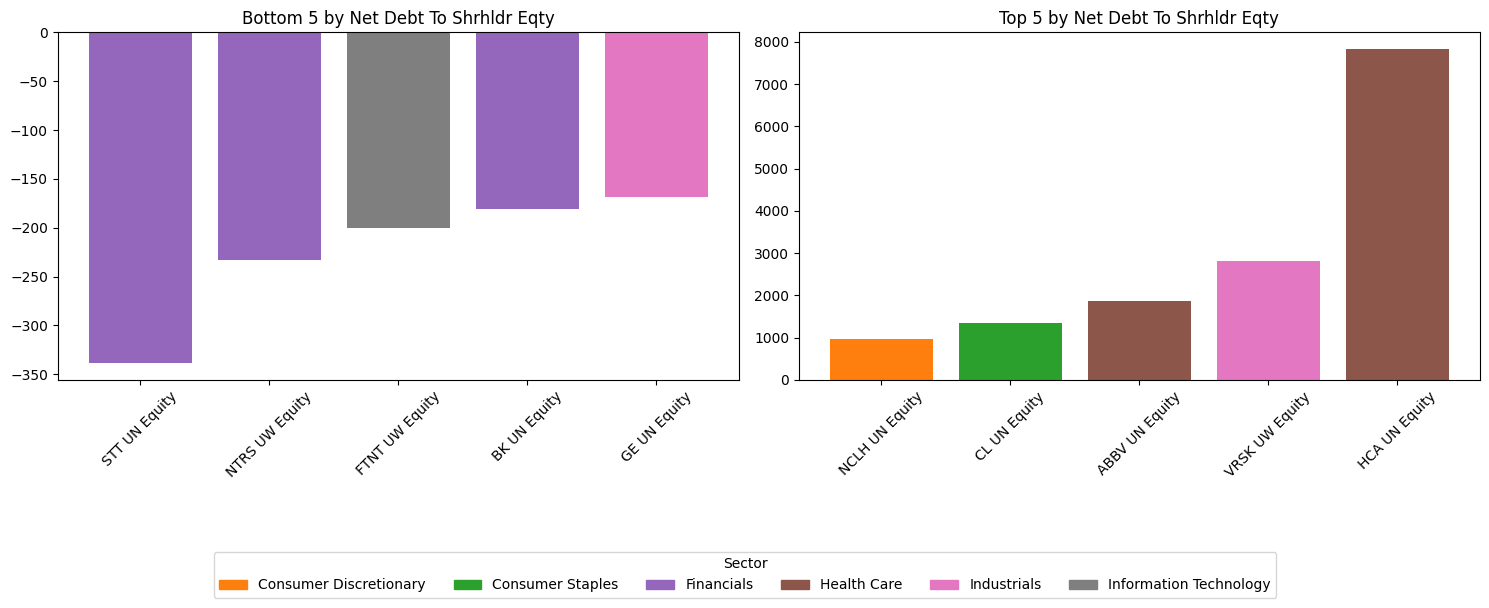

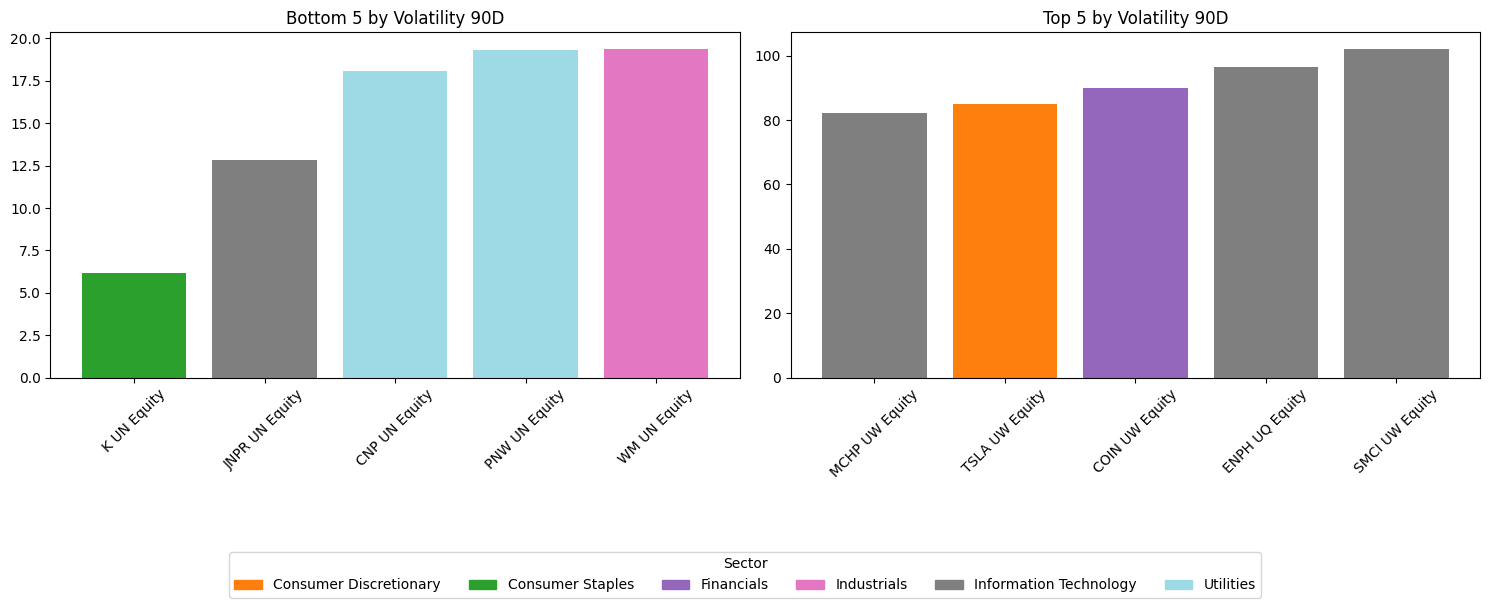

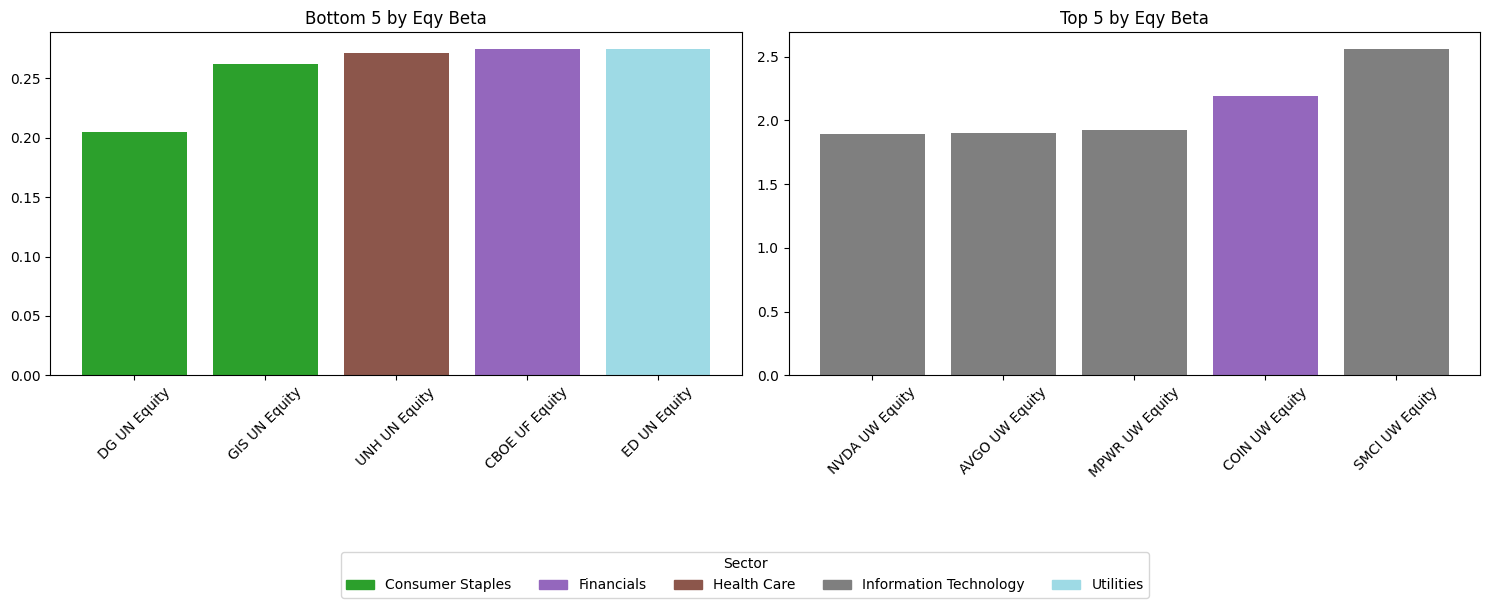

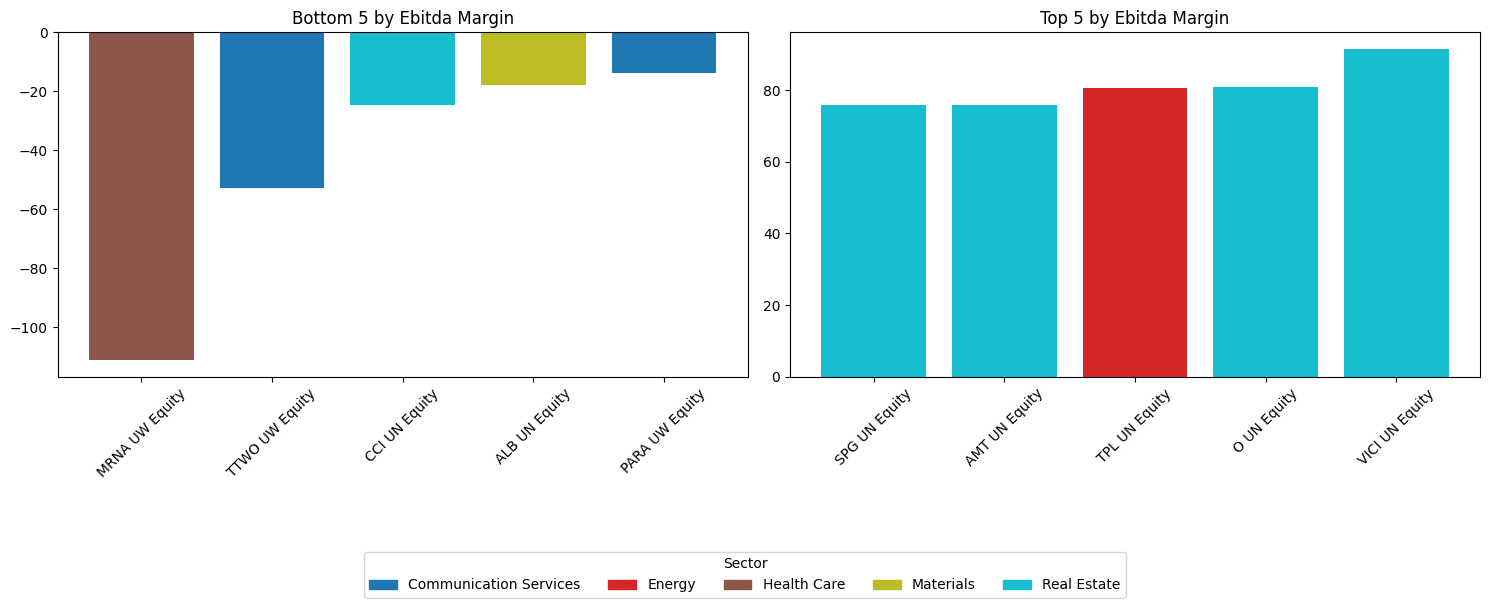

In [5]:
# # ----------------------------------------
# # TOP & BOTTOM STOCKS PER METRIC
# # ----------------------------------------
# ticker_to_sector = bdp_df['gics_sector_name']
# for m in metrics:
#     if m not in bdp_df.columns: continue
#     series = pd.to_numeric(bdp_df[m], errors='coerce').dropna()
#     if len(series) < 2: continue
#     top5 = series.nlargest(5)
#     bot5 = series.nsmallest(5)
#     fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=False)
#     bot = bot5.sort_values()
#     axes[0].bar(bot.index, bot.values, color=[color_map[ticker_to_sector.loc[t]] for t in bot.index])
#     axes[0].set_title(f"Bottom 5 by {m.replace('_', ' ').title()}")
#     axes[0].tick_params(axis='x', rotation=45)
#     top = top5.sort_values()
#     axes[1].bar(top.index, top.values, color=[color_map[ticker_to_sector.loc[t]] for t in top.index])
#     axes[1].set_title(f"Top 5 by {m.replace('_', ' ').title()}")
#     axes[1].tick_params(axis='x', rotation=45)
#     unique_secs = sorted({ticker_to_sector.loc[i] for i in list(bot.index)+list(top.index)})
#     handles = [mpatches.Patch(color=color_map[s], label=s) for s in unique_secs]
#     fig.legend(handles=handles, title='Sector', bbox_to_anchor=(0.5,-0.1), loc='upper center', ncol=len(handles))
#     plt.tight_layout()
#     plt.show()